# Dataset, DataLoader
데이터를 처리하여 model에 공급(fit)하기 위하여 파이토치에서 torch.utils.data.Dataset과 torch.utils.data.DataLoader 클래스를 지원합니다.

- Dataset : feature와 label을 저장할 수 있습니다.
- DataLoader : Dataset을 모델에 공급할 수 있도록하는 클래스 입니다.

In [17]:
import torch

# torchvision : 파이토치 기반의 CV 도구들이 들어있는 패키지
# torchvision.datasets : Computer Vision 관련 예제 데이터 세트

from torchvision import datasets
from torchvision.transforms import ToTensor

In [18]:
train_data = datasets.FashionMNIST(
    root="../../data",  # 데이터(이미지)를 저장할 디렉토리
    train=True,  # 훈련용 데이터 여부
    download=True,  # 다운로드
    transform=ToTensor(),  # 이미지 변환. 여기서는 ndarray형식의 이미지를 pytorch tensor로 변환
)

# Dataset 시각화

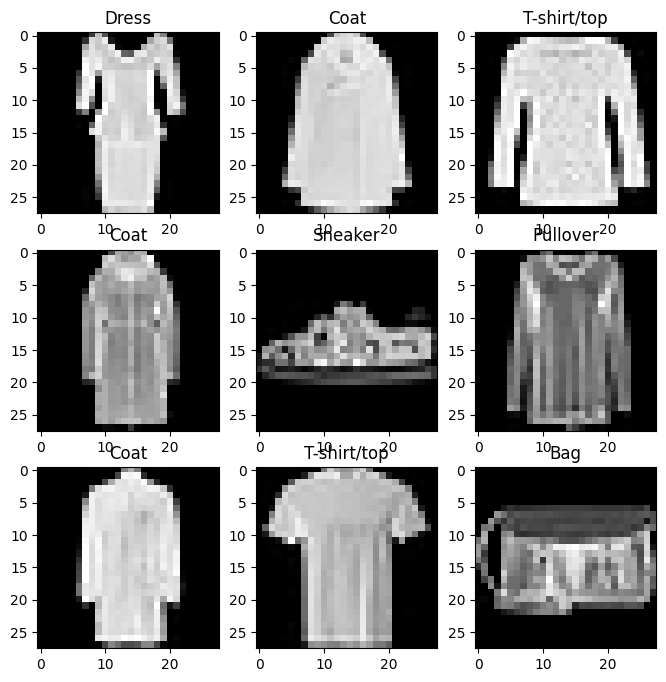

In [19]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()

    # Dataset에서 데이터를 뽑을 예정. 이 때 Dataset의 구조는 feature, target이 같이 들어있다.
    feature, target = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)

    plt.title(labels_map[target])
    plt.imshow(feature.squeeze(), cmap="gray")

plt.show()

# DataLoader 만들기

In [20]:
BATCH_SIZE = 64

In [21]:
from torch.utils.data import DataLoader

# shuffle : 1에폭 당 데이터 로더에서 데이터를 읽어 올 때 마다 랜덤하게 섞게 된다.
#   shuffle을 걸어주면 모델이 데이터를 조금 더 어렵게 학습한다.
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
# 테스트 데이터 불러오기
test_data = datasets.FashionMNIST(
    root="../../data", train=False, download=True, transform=ToTensor()
)

# 테스트 데이터 세트는 굳이 섞을 필요가 없다. 어차피 전체 데이터에 대한 성능(loss, accuracy)를 확인만 하기 때문에
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## DataLoader 시각화
- DataLoader 객체는 파이썬의 Generator 자료구조에 해당하며, Iterator를 직접 움직여 가면서 데이터를 Iterate 할 수 있습니다.
- 이 때 설정한 BATCH_SIZE 만큼 데이터를 추출해 냅니다.

In [23]:
# dataloader의 Iterator가 한칸 움직일 때 마다(next) BATCH_SIZE만큼 데이터를 가져온다.
train_features, train_labels = next(iter(train_dataloader))
print(train_features.size())
print(train_labels.size())

torch.Size([64, 1, 28, 28])
torch.Size([64])


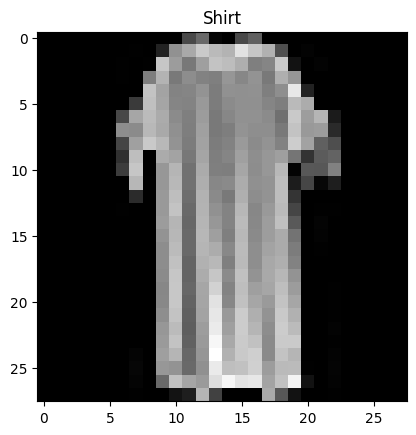

In [24]:
train_features, train_labels = next(iter(train_dataloader))

feature = train_features[0].squeeze()
label = train_labels[0].item()

plt.title(labels_map[label])
plt.imshow(feature, cmap="gray")
plt.show()

# CustomDataset ⭐️
`torch.utils.data.Dataset` 클래스를 상속받으면 개발자가 직접 파이토치 Dataset을 구성할 수 있습니다. 필수로 오버라이딩 해야하는 메소드는 다음과 같습니다.
- `__init__` : 생성자 입니다. Dataset 에 담을 데이터, 전처리가 필요하다면 `transform` 객체를 같이 받습니다.
- `__len__` : Dataset에 있는 데이터의 개수
- `__getitem__` : 몇 번째 데이터를 가져올지를 정의하는 함수입니다. 만약 `transform`이 있다면 변환 처리까지 해주게 됩니다.

In [25]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, features, transform=None):
        self.features = features
        self.transform = transform
        self.len = features.shape[
            0
        ]  # 항상 shape의 첫 번째에는 데이터의 전체 개수가 들어있다.

    def __len__(self):
        # __len__ 메소드는 len() 함수를 호출 했을 때 자동으로 실행되는 매직 메소드
        return self.len

    def __getitem__(self, idx):
        # __getitem__ 메소드는  [ ] 기호를 이용해서 아이템을 뽑아낼 때 호출되는 매직 메소드(연산자 오버로딩)
        feature = self.features[idx]

        if self.transform:
            feature = self.transform(feature)

        return feature

In [26]:
# 사용자 정의 데이터 변환기(transform) 만들기
def square(data):
    # 데이터를 제곱하는 데이터 변환기
    return data**2

In [27]:
# 개발자가 직접 만든 함수를 파이토치의 변환기로 등록
import torchvision.transforms as tr

transform = tr.Compose([square])
transform

Compose(
    <function square at 0x14f7c74c0>
)

In [28]:
import numpy as np

sample_data = np.arange(10)
custom_ds = CustomDataset(sample_data, transform=transform)

In [29]:
len(custom_ds)

10

In [30]:
custom_ds[4]

16

In [31]:
custom_dl = DataLoader(custom_ds, batch_size=3, shuffle=True)

In [32]:
for _ in range(3):
    for data in custom_dl:
        print(data)

    print("=" * 20)

tensor([ 1,  0, 81])
tensor([ 9, 36, 16])
tensor([ 4, 49, 25])
tensor([64])
tensor([ 0,  4, 36])
tensor([ 9,  1, 64])
tensor([81, 49, 25])
tensor([16])
tensor([16,  0, 49])
tensor([81,  9, 64])
tensor([25, 36,  4])
tensor([1])
